# Video pipeline with Yolo + Resnet Model

In [1]:
import os
import sys
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from typing import Dict, List

pp = PrettyPrinter(indent=4)
from barazmoon.twitter import twitter_workload_generator

# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import FINAL_RESULTS_PATH
from experiments.utils.parser import AdaptationParser
from experiments.utils.drawing import draw_temporal, draw_cumulative

In [2]:
# serieses = [116, 117, 118, 119, 120]
serieses = [153, 154]

series_paths = {series: os.path.join(FINAL_RESULTS_PATH, "series", str(series)) for series in serieses}

loaders = {series: AdaptationParser(series_path=series_path, model_name="video", type_of="router_pipeline") for series, series_path in series_paths.items()}

In [3]:
loaders

{153: <experiments.utils.parser.AdaptationParser at 0x7f02116968e0>,
 154: <experiments.utils.parser.AdaptationParser at 0x7f021170ac10>}

In [4]:
accuracy_methods = {}
adaptation_intervals = {}
simulation_modes = {}
configs = {}
for series, loader in loaders.items():
    configs_exp = loader.load_configs()
    print(f"series: {series} config:\n")
    config = configs_exp['0.yaml']
    pp.pprint(config)
    configs[series] = config
    accuracy_methods[series] = config["accuracy_method"]
    adaptation_intervals[series] = config["adaptation_interval"]
    simulation_modes[series] = config["simulation_mode"]

series: 153 config:

{   'accuracy_method': 'sum',
    'adaptation_interval': 20,
    'allocation_mode': 'base',
    'alpha': 0,
    'baseline_mode': 'scale',
    'batching_cap': 64,
    'benchmark_duration': 1,
    'beta': 1,
    'central_queue': True,
    'debug_mode': False,
    'distrpution_time': 30,
    'drop_limit': 10000,
    'gamma': 0,
    'initial_active_model': ['yolov5n', 'resnet18'],
    'initial_batch': [1, 1],
    'initial_cpu_allocation': [1, 1],
    'initial_replica': [1, 1],
    'latency_margin': 0,
    'metadata': 'teleport 10 and margin 30%',
    'mode': 'exponential',
    'model_name': ['yolo', 'resnet-human'],
    'monitoring_duration': 10,
    'nodes': [   {   'cpu_request': '1',
                     'data_type': 'image',
                     'max_batch_size': '1',
                     'max_batch_time': '1',
                     'memory_request': '2Gi',
                     'model_variants': 'yolov5n',
                     'node_name': 'yolo',
                  

In [5]:
# load the sent workload
sent_loads = {}
for series, config in configs.items():
    workload_type = config["workload_type"]
    workload_config = config["workload_config"][0]
    start = workload_config["start"]
    end = workload_config["end"]
    damping_factor = workload_config["damping_factor"]
    sent_loads[series] = twitter_workload_generator(
        days=f"{start}-{end}", damping_factor=damping_factor
    )

In [6]:
# key_config_df = loader.loader.key_config_mapper()
# display(key_config_df)
# key_config_df.columns
results_all = []
simulation_modes

{153: False, 154: False}

In [7]:
adaptation_logs = dict(map(lambda l: (l[0], l[1].load_adaptation_log()), loaders.items()))

In [8]:
series_changes = {}
for series in serieses:
    series_changes[series] = loaders[series].series_changes(adaptation_log=adaptation_logs[series])

## Comparing Predicted Load with the Recieved Load

300
290


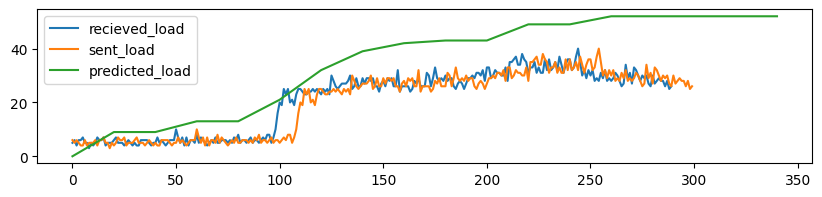

300
290


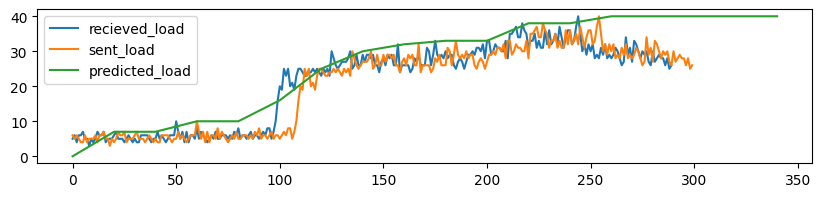

In [33]:
# --- sent and recieved load ---
for series, series_dict in series_changes.items():
    recieved_load = series_changes[series]["recieved_load"]
    predicted_load = series_changes[series]["predicted_load"]
    # recieved_load = [int(item) for item in recieved_load if item != 0]
    recieved_load_x = [x for x in range(0, len(recieved_load))]
    sent_load_x = [x for x in range(0, len(sent_loads[series]))]
    predicted_load_x = series_changes[series]["time_interval"]
    print(len(sent_loads[series]))
    print(len(recieved_load))
    plt.figure(figsize=(10, 2))
    plt.plot(recieved_load_x, recieved_load, label="recieved_load")
    plt.plot(sent_load_x, sent_loads[series], label="sent_load")
    plt.plot(predicted_load_x, predicted_load, label="predicted_load")
    # TODO add predicted reference load here
    plt.legend()
    plt.show()


0 out of 6103
513 out of 6103


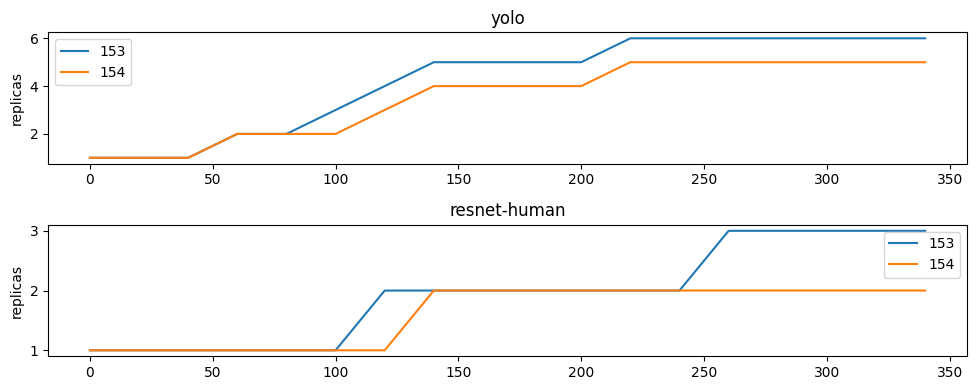

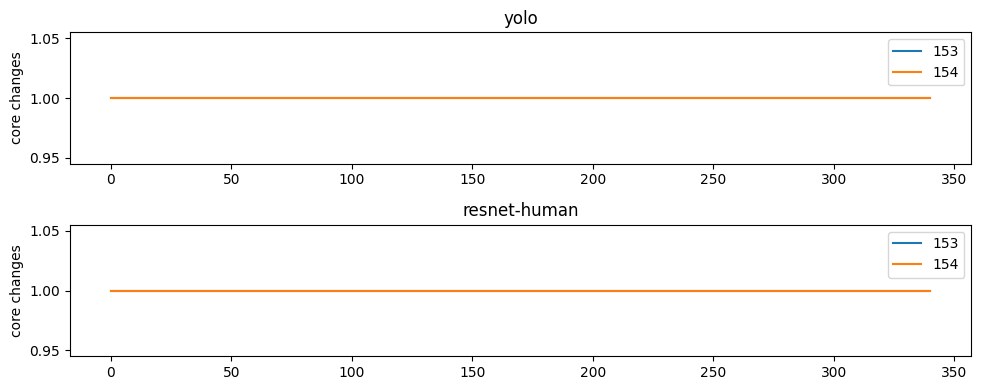

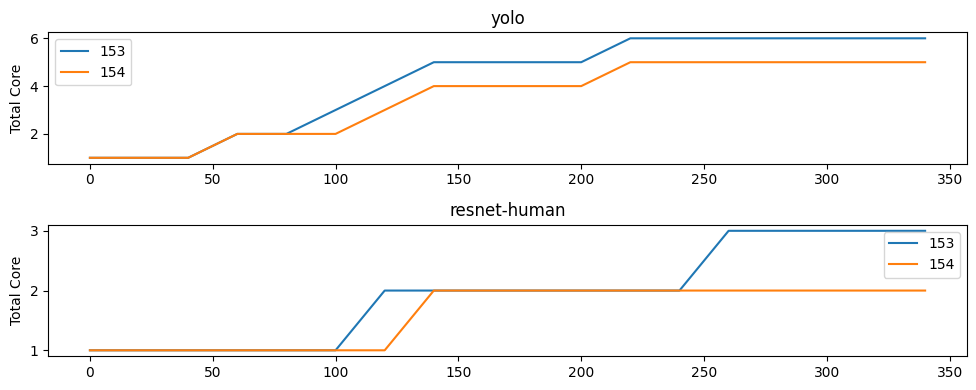

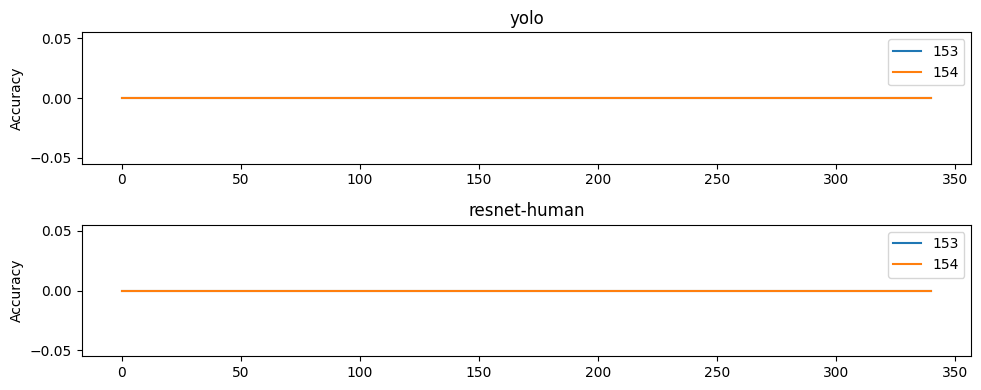

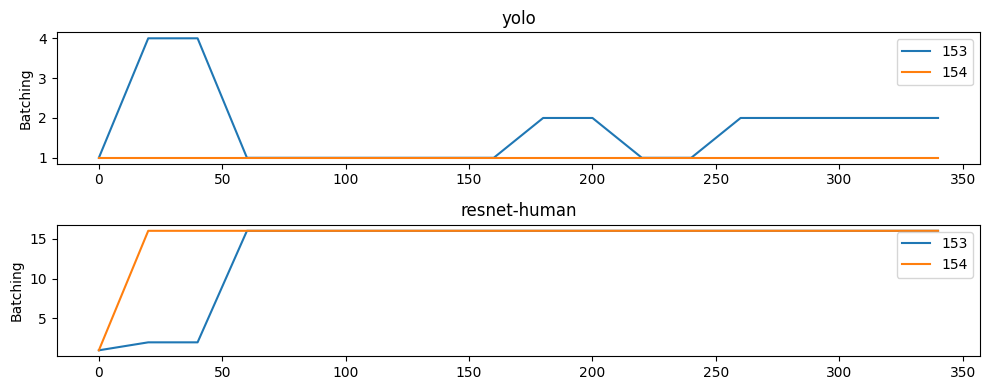

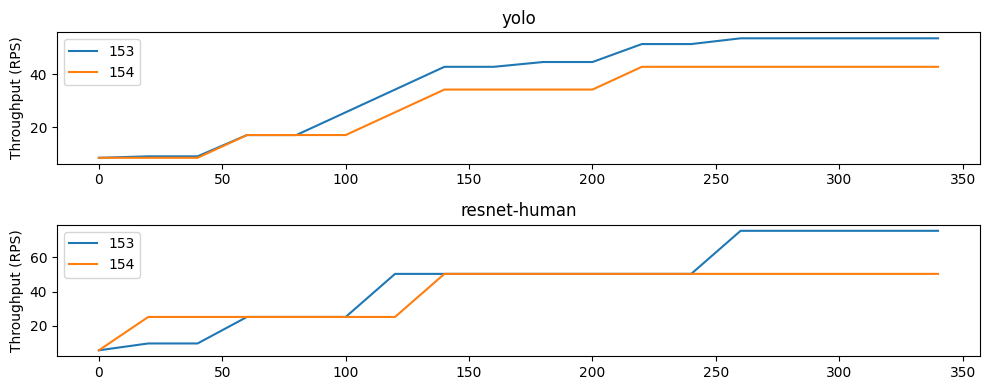

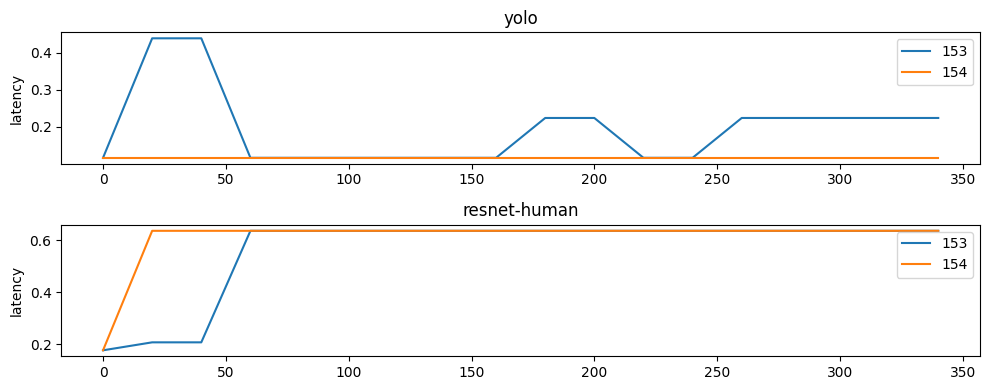

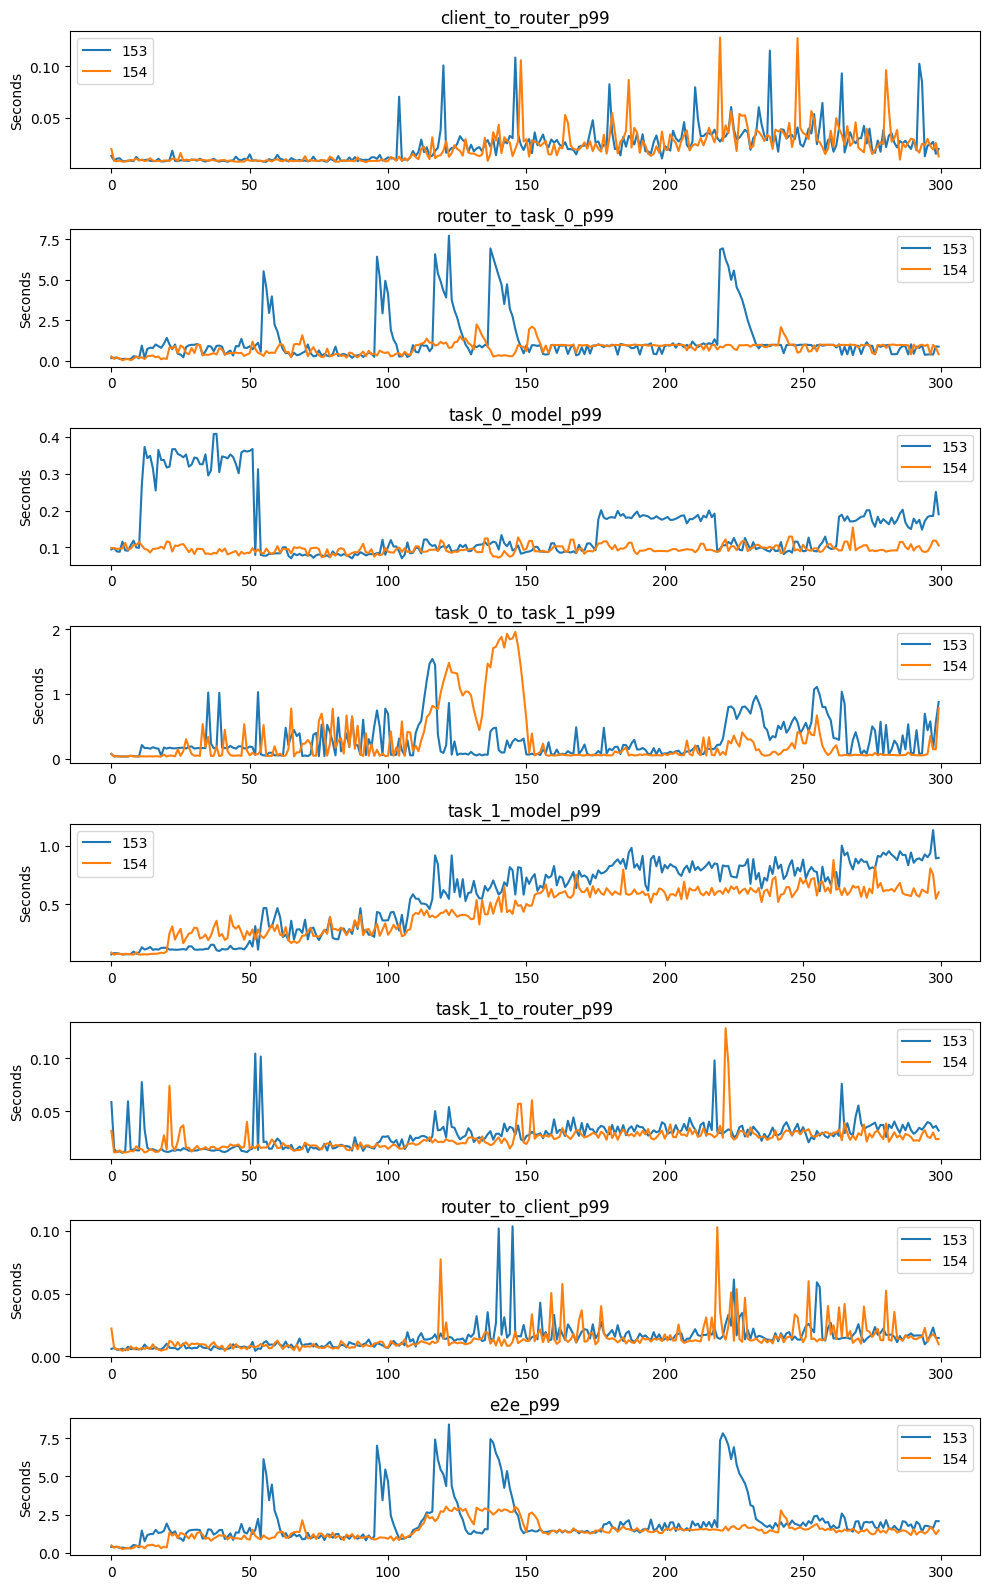

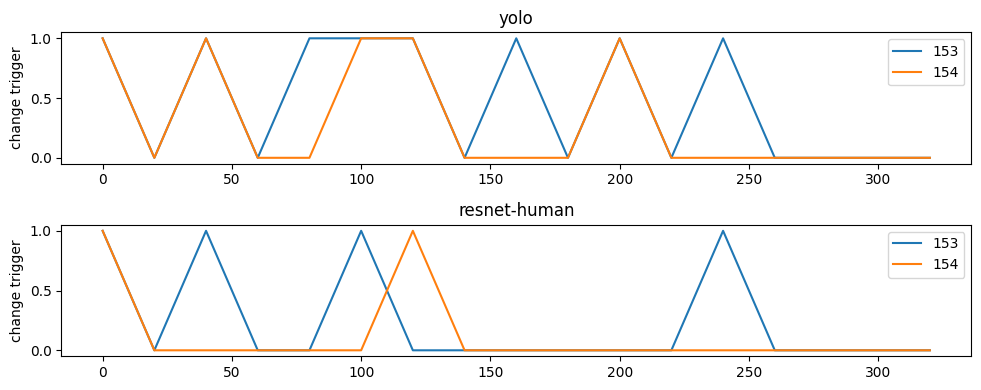

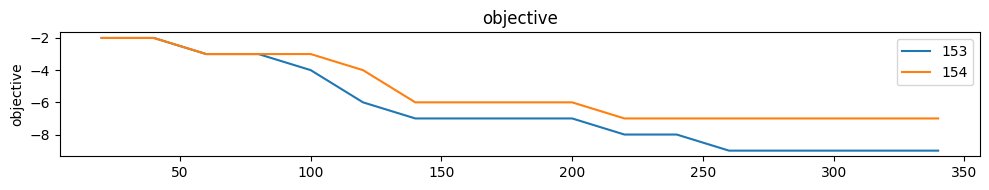

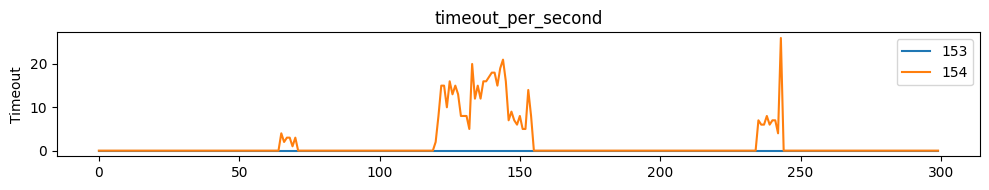

In [36]:

# --- replica changes ---
final_dict = {}
final_dict["replica_changes"] = {}
final_dict["core_changes"] = {}
final_dict["total_core_changes"] = {}
final_dict["accuracy_changes"] = {}
final_dict["batching_changes"] = {}
final_dict["throughput_changes"] = {}
final_dict["latency_changes"] = {}
final_dict["timeout_per_second"] = {}
final_dict["per_second_results"] = {}
final_dict["metric"] = "p99" # [min, max, p99]
final_dict["metrics_all"] = {}
final_dict["change_trigger"] = {}
final_dict["objective_changes"] = {}
final_dict["timeout_dics"] = {}

for series, series_dict in series_changes.items():

    final_dict["replica_changes"][series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        final_dict["replica_changes"][series][node_name] = metrics["replicas"]
        nodes.append(node_name)

    final_dict["core_changes"][series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        final_dict["core_changes"][series][node_name] = metrics["cpu"]
        nodes.append(node_name)

    final_dict["total_core_changes"][series] = {}
    for key in final_dict["replica_changes"][series].keys():
        final_dict["total_core_changes"][series][key] = [
            x * y for x, y in zip(final_dict["replica_changes"][series][key], final_dict["core_changes"][series][key])
        ]

    final_dict["accuracy_changes"][series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        final_dict["accuracy_changes"][series][node_name] = metrics["accuracy"]
        nodes.append(node_name)

    final_dict["batching_changes"][series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        final_dict["batching_changes"][series][node_name] = metrics["batch"]
        nodes.append(node_name)

    final_dict["throughput_changes"][series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        final_dict["throughput_changes"][series][node_name] = metrics["throughput"]
        nodes.append(node_name)

    final_dict["latency_changes"][series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        final_dict["latency_changes"][series][node_name] = metrics["latency"]
        nodes.append(node_name)
    if not simulation_modes[series]:
        final_dict["timeout_per_second"][series], final_dict["per_second_results"][series] = loaders[series].per_second_result_processing()
    else:
        final_dict["timeout_per_second"][series], final_dict["per_second_results"][series] = None, None
    if not simulation_modes[series]:
        metric_columns = list(filter(lambda col: final_dict["metric"] in col, final_dict["per_second_results"][series].columns))
        final_dict["metrics_all"][series] = final_dict["per_second_results"][series][metric_columns]
        final_dict["metrics_all"][series] = final_dict["metrics_all"][series].to_dict(orient="list")

    final_dict["change_trigger"][series] = {}
    final_dict["change_trigger"][series] = loader.points_with_change(adaptation_log=adaptation_logs[series])

    final_dict["objective_changes"][series] = {}
    final_dict["objective_changes"][series]["objective"] = series_changes[series]["objective"]

    if not simulation_modes[series]:
        final_dict["timeout_dics"][series] = {"timeout_per_second": final_dict["timeout_per_second"][series]}
        print(f"{sum(final_dict['timeout_per_second'][series])} out of {sum(sent_loads[series])}")


# totals
final_dict["replica_changes"][series]["total"] = [sum(x) for x in zip(*final_dict["replica_changes"][series].values())]
final_dict["core_changes"][series]["total"] = [sum(x) for x in zip(*final_dict["core_changes"][series].values())]
if accuracy_methods[series] == "sum":
    final_dict["accuracy_changes"][series]["e2e"] = [sum(x) for x in zip(*final_dict["accuracy_changes"][series].values())]
final_dict["throughput_changes"][series]["e2e"] = [min(x) for x in zip(*final_dict["throughput_changes"][series].values())]
final_dict["latency_changes"][series]["e2e"] = [sum(x) for x in zip(*final_dict["latency_changes"][series].values())]
final_dict["change_trigger"][series]["all"] = [any(x) for x in zip(*final_dict["change_trigger"][series].values())]

# drawings
ylabel="replicas"
draw_temporal(final_dict["replica_changes"], adaptation_intervals, ylabel=ylabel, multiple_experiments=True)
ylabel="core changes"
draw_temporal(final_dict["core_changes"], adaptation_intervals, multiple_experiments=True, ylabel=ylabel)
ylabel="Total Core"
draw_temporal(final_dict["total_core_changes"], adaptation_intervals, multiple_experiments=True, ylabel=ylabel)
ylabel="Accuracy"
draw_temporal(final_dict["accuracy_changes"], adaptation_intervals, multiple_experiments=True, ylabel=ylabel)
ylabel = "Batching"
draw_temporal(final_dict["batching_changes"], adaptation_intervals, multiple_experiments=True, ylabel=ylabel)
ylabel = "Throughput (RPS)"
draw_temporal(final_dict["throughput_changes"], adaptation_intervals, multiple_experiments=True, ylabel=ylabel)
ylabel = "latency"
draw_temporal(final_dict["latency_changes"], adaptation_intervals, multiple_experiments=True, ylabel=ylabel)
ylabel = "Seconds"
draw_temporal(final_dict["metrics_all"], multiple_experiments=True, ylabel=ylabel)
ylabel = "change trigger"
draw_temporal(final_dict["change_trigger"], adaptation_intervals, multiple_experiments=True, ylabel=ylabel)
ylabel = "objective"
draw_temporal(final_dict["objective_changes"], adaptation_intervals, multiple_experiments=True, ylabel=ylabel)
ylabel = "Timeout"
draw_temporal(final_dict["timeout_dics"], multiple_experiments=True, ylabel=ylabel)

# --- changes in the series ---
# for series in serieses:
#     print(50 * "-" + f" {series} " + 50 * "-")
#     for key, value in series_changes[series].items():
#         if key == "nodes":
#             for node_name, all_configs in value.items():
#                 print(f"node: {node_name}\n")
#                 for config_name, config_values in all_configs.items():
#                     print(f"{config_name}: {config_values}")

# Paper ready figures

In [23]:
"""
1. Temporal could be on the showing both nodes
2. 
"""

'\n1. Temporal could be on the showing both nodes\n2. \n'